
## Image Registration using Enhanced Correlation Coefficient (ECC) Maximization

Using an actual rotation and original image (along with histogram normalization). 

In [1]:
import numpy as np
import cv2
from skimage.external import tifffile as tiff
from skimage.util import img_as_float
from skimage import exposure
from skimage.filters import try_all_threshold, threshold_li
from skimage.transform import rescale
from skimage.transform import warp, AffineTransform, resize
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline


[[  0 106 112 ...,  63  71  82]
 [110 105 119 ...,  71  79  76]
 [103 106 105 ...,  68  60  64]
 ..., 
 [ 67  74  68 ..., 104 118 113]
 [ 77  81  73 ..., 108  86 116]
 [ 72  80  79 ..., 107 109 103]]
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


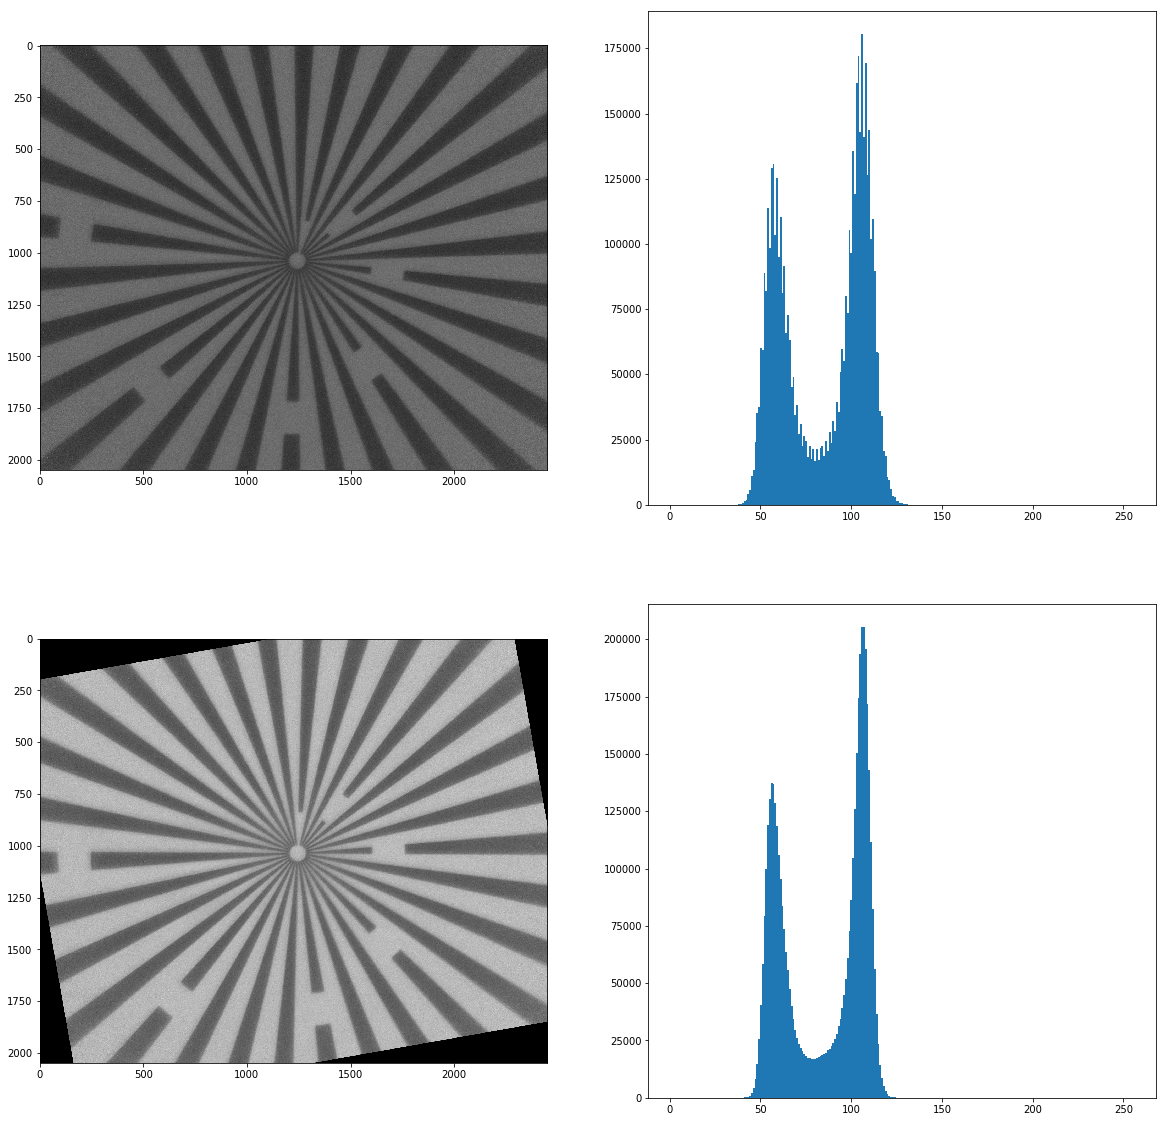

In [15]:
samples = ['../samples/rot_0.tif', 
           '../samples/rot_180.tif',
           '../samples/faked_rot_0_tilted_5.3deg.tif',
           '../samples/faked_rot_180.tif']

img0deg = img_as_float(tiff.imread(samples[0]))
img0deg = rescale_intensity(img0deg)
img0deg = img0deg * 255.0
img0deg = img0deg.astype(np.uint8)

# img1deg = img_as_float(tiff.imread(samples[2]))
# img1deg = cv2.flip(img1deg, 1)

rows, cols = img0deg.shape

M = cv2.getRotationMatrix2D((cols/2, rows/2), 10, 1)
img1deg = cv2.warpAffine(img0deg, M, (cols, rows))


print (img0deg)
print (img1deg)


# print (np.min(img0deg), np.max(img0deg))
# print (np.min(img1deg), np.max(img1deg))

# img0deg = img0deg * 255.0
# img0deg = img0deg.astype(np.uint8)

# img1deg =img1deg * 255.0
# img1deg = img1deg.astype(np.uint8) 


# img0deg = cv2.equalizeHist(img0deg)
# img1deg = cv2.equalizeHist(img1deg)


f, ax = plt.subplots(2, 2, figsize=(20,20))
ax[0, 0].imshow(img0deg, cmap='gray')
ax[0, 1].hist(img0deg.ravel(), 255, [1, 255])
ax[1, 0].imshow(img1deg, cmap='gray')
ax[1, 1].hist(img1deg.ravel(), 255, [1, 255])

plt.show()


In [28]:
def preProcess(image, rs=0.3):
    tmp = rescale(image, rs, mode='reflect')
    thresh = threshold_li(tmp)
    binary = tmp > thresh
    result = np.zeros_like(binary, dtype=np.uint8)
    result[~binary] = 255
    
    return result

def computeRotation(template, src, warp_matrix=None):
    sz = src.shape
    warp_mode = cv2.MOTION_EUCLIDEAN

    if warp_matrix == None:
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    number_of_iterations = 5000
    termination_eps = 1e-10

    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC (template, src, warp_matrix, warp_mode, criteria)
    
    return warp_matrix

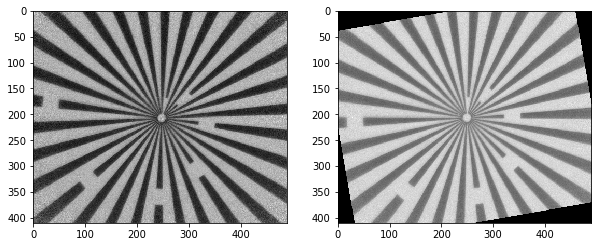

In [34]:
img0 = rescale(img0deg, 0.2, mode='reflect')
img1 = rescale(img1deg, 0.2, mode='reflect')

img0 = img0 - img0.mean()
img1 = img1 - img1.mean()


f, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img0, cmap='gray')
ax[1].imshow(img1, cmap='gray')

plt.show()

/local/fkhan/anaconda3/envs/RoboND/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


1.99212691083


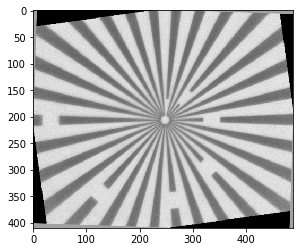

In [35]:
img0 = img0.astype(np.float32)
img1 = img1.astype(np.float32)

warp_matrix = computeRotation(img1, img0)
warp_matrix = computeRotation(img1, img0, warp_matrix)

sin = warp_matrix[0, 1]
cos = warp_matrix[0, 0]
    
degs = np.arctan2(sin, cos) * 180.0 / np.pi

print (degs)

imgAligned = cv2.warpAffine(img1, warp_matrix, (img1.shape[1], img1.shape[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

plt.imshow(imgAligned, cmap='gray')
plt.show()

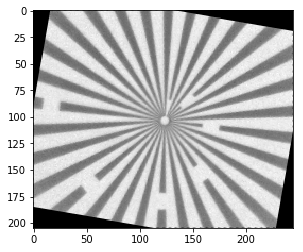

In [12]:
rows, cols = img1.shape

M = cv2.getRotationMatrix2D((cols/2, rows/2), -10, 1)
out = cv2.warpAffine(img1, M, (cols, rows))

plt.imshow(out, cmap='gray')